# The Quench Experiments

Starting from the state $\ket{Z_i}$ we first evolve with a $P_0$ distribution over measurments for some number of full steps (in ubits of system size) and then switch to the probed distribution $P_1$.

The measurements done will be:
1. Topological Entanglement Entropy
2. Topological Entanglement Negativity

In [23]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
include("AdditionalStructure/NewTypes.jl")
include("AdditionalStructure/BitStringOps.jl")
include("AdditionalStructure/Measurements.jl")
include("AdditionalStructure/MICModels.jl")
include("AdditionalStructure/ModelRuns.jl")
include("AdditionalStructure/Iterators.jl");

iterate_measurements_only! (generic function with 1 method)

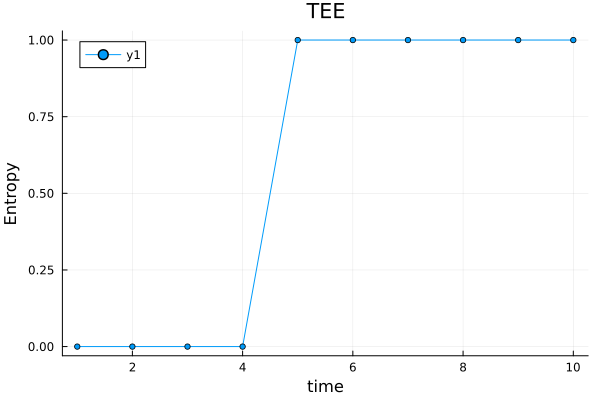

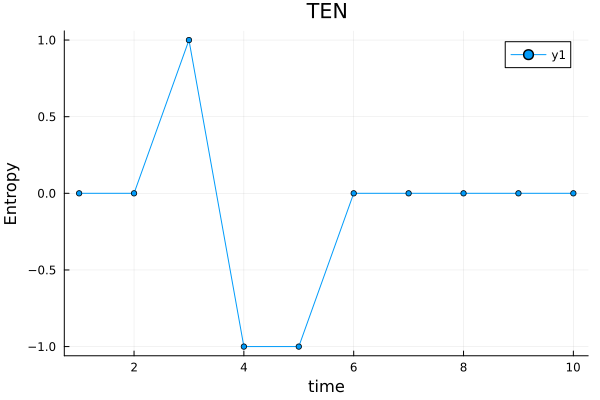

[0.0 0.0 1.0 -1.0 -1.0 0.0 0.0 0.0 0.0 0.0][0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0]

In [24]:
# Toric Code 

stab_distro_intial = Categorical([1/2, 1/2, 0, 0, 0, 0, 0, 0]) 
# Probability Distros over Stabiliser used to define the TC anyon Profileration. Very TC specific!
p_b = 0 # Boson Measurement
p_f = 0 # Fermion Measurement
stab_distro_probed = Categorical([(1-p_b-p_f)/2, (1-p_b-p_f)/2, p_b/2, p_b/2, 0, 0, p_f/2, p_f/2])

subsystem = 4
system = Init_EdgeSquareLattice(4)

anneal_steps = 0
quench_steps = 10 # Sample this lineraly (upgrade to log sampling if needed)
number_of_samples = 10
steps_per_sample = Int(quench_steps/number_of_samples)
sample_times = 1:steps_per_sample:quench_steps
number_of_runs = 1
TEEs = zeros(number_of_runs, number_of_samples)
TENs = zeros(number_of_runs, number_of_samples)

for i_run = 1:number_of_runs
    state = MixedDestabilizer(Stabilizer(zeros(UInt8, system.nbits), 
                                        zeros(Bool, system.nbits, system.nbits), 
                                        Matrix(LinearAlgebra.I, system.nbits, system.nbits)))
    iterate_measurements_only!(state, system, () -> toric_code(system, stab_distro_intial), anneal_steps)
    # Annealing the Z state to a TC logic state
    for i_sample = 1:number_of_samples
        TEEs[i_run, i_sample] = entanglement_entropy_topo(state, system)
        TENs[i_run, i_sample] = entanglement_negativity(state, system)
        iterate_measurements_only!(state, system, () -> toric_code(system, stab_distro_probed), steps_per_sample)
    end
end

TENs = sum(TENs, dims=1)/number_of_runs
TEEs = sum(TEEs, dims=1)/number_of_runs

# plot entropy as function of time
p = plot(sample_times, TEEs',
    title="TEE",
    xlabel="time",
    ylabel="Entropy",
    marker=(:circle, 3))
q = plot(sample_times, TENs',
    title="TEN",
    xlabel="time",
    ylabel="Entropy",
    marker=(:circle, 3))
# gui()  # this is the equivalent of matplotlibs show()
# Note: not needed since we are plotting in the cell (with added name to the plot "p")
display(p)
display(q)
print(TENs)
print(TEEs)
